# Running the TTGammaProcessor

This cell will copy the test files from their location on eos to your local area. This only needs to be done once!

In [1]:
%load_ext autoreload
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import time
import hist

In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

List of samples to be run on (fileset variable) and a dictionary containing the number of events processed for each sample

In [3]:
fileset = {
    "TTGamma_SingleLept": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/TTGamma_1l.root"
    ],
    "TTbarPowheg_Semilept": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2021/long_exercises/TTGamma/TestFiles/TTbar_1l.root"
    ],
    "W4jets": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2022/long_exercises/TTGamma/TestFiles/W4Jets.root"
    ],
    "WGamma_01J_5f": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2023/long_exercises/TTGamma/TestFiles/WGamma.root"
    ],
    "ZGamma_01J_5f_lowMass": [
        "root://cmseos.fnal.gov//store/user/cmsdas/2024/long_exercises/TTGamma/TestFiles/ZGamma.root"
    ],
}

Run the TTGammaProcessor on the list of files included in fileset.

You can specify the chunksize and maximum number of chunks to process from each sample (selecting a small number of events and one chunk will force coffea to process only a subset of the events for quicker debugging)

In [4]:
#autoreload forces the kernel to reload the processor to include any new changes
%autoreload 2
from ttgamma import TTGammaProcessor

tstart = time.time()

#Run Coffea code using uproot
iterative_run = processor.Runner(
    executor = processor.IterativeExecutor(compression=None),
    schema=NanoAODSchema,
    chunksize=40_000,
    maxchunks=1,
)
output = iterative_run(
    fileset,
    treename="Events",
    processor_instance=TTGammaProcessor(isMC=True),
)

elapsed = time.time() - tstart
print("Total time: %.1f seconds"%elapsed)

Output()

Output()

Total time: 53.5 seconds


[]

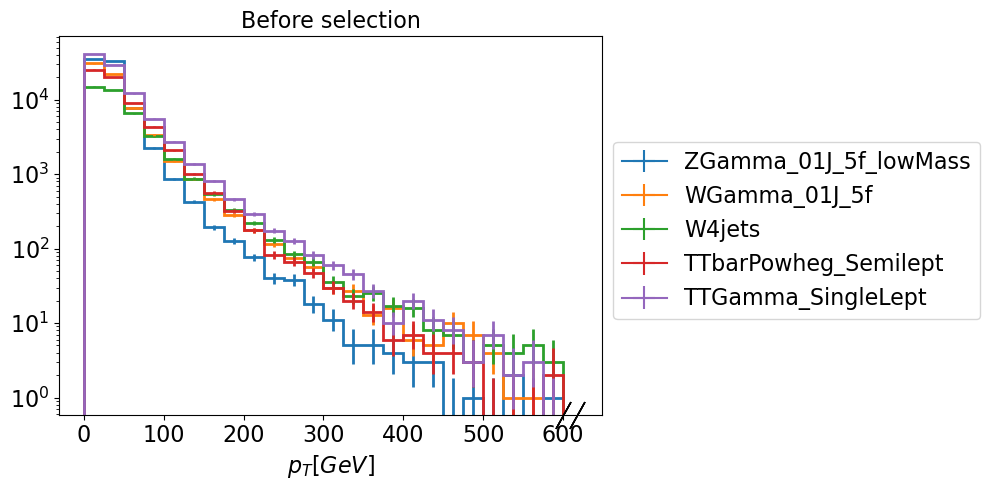

In [91]:
import hist
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10,5))

for ds, histos in output.items():
    h = histos["all_photon_pt"]
    h = h[{'pt': hist.tag.Slicer()[0j:600j]}]
    h = h[::5j]
    h.plot1d(ax=ax, label=ds, lw=2)

ax.legend(bbox_to_anchor=(1,0.75),fontsize=16)
plt.title("Before selection", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$p_T [GeV]$",fontsize=16)

ax.set_yscale("log")
plt.tight_layout()
plt.savefig('Event_selection_start_log.png')
plt.plot()

/usr/local/lib/python3.10/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


[]

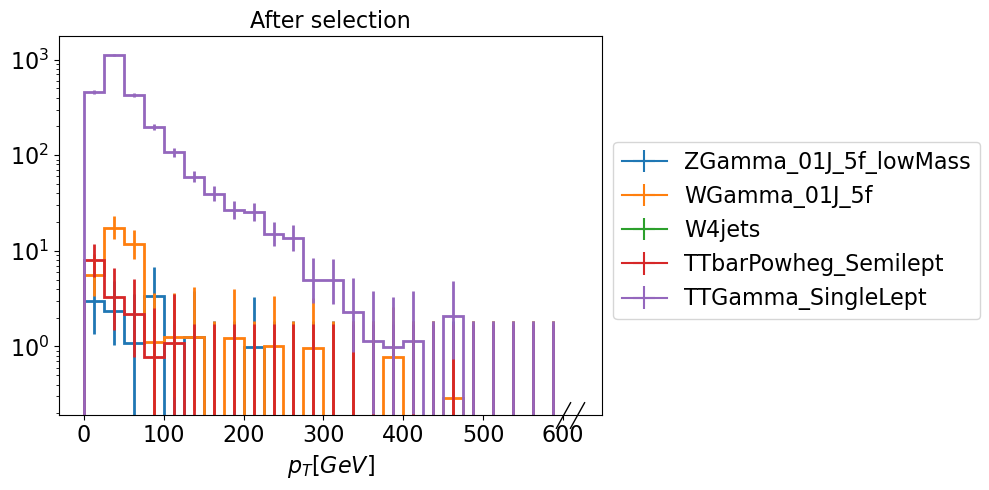

In [92]:
fig, ax = plt.subplots(figsize=(10,5))

for ds, histos in output.items():
    h = histos["photon_pt"]
    if ds != 'W4jets':
        h = h[{'pt': hist.tag.Slicer()[0j:600j],"category": sum, "lepFlavor": sum, "systematic": "nominal"}]
        h = h[::5j]
    else:
        h = h[{'pt': hist.tag.Slicer()[0j:600j],"category": sum, "lepFlavor": sum, "systematic": sum}]
    h.plot1d(ax=ax, label=ds, lw=2)

ax.legend(bbox_to_anchor=(1,0.75),fontsize=16)
plt.title("After selection", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$p_T [GeV]$",fontsize=16)

ax.set_yscale("log")
plt.tight_layout()
plt.savefig('Event_selection_final_log.png')

plt.plot()

In [7]:
expected = util.load("output_Expected.coffea")

hname = "photon_chIso"
for ds, histo in expected.items():
    mine = output[ds][hname].values()
    other = expected[ds][hname].values()
    if mine.shape != other.shape:
        print(f"For dataset {ds} there is a mismatch in axes")
    elif not np.all(mine == other):
        print(f"For dataset {ds} there is a mismatch in bin yields")
    else:
        print(f"All good for {ds}")

print("Done!")

For dataset ZGamma_01J_5f_lowMass there is a mismatch in axes
For dataset WGamma_01J_5f there is a mismatch in axes
For dataset W4jets there is a mismatch in axes
For dataset TTbarPowheg_Semilept there is a mismatch in axes
For dataset TTGamma_SingleLept there is a mismatch in axes
Done!


# Accessing Arrays Interactively

Below is an example of loading a NanoAOD file interactively. This can be very useful for developing the code, and debugging any issues. Use this area to build your intuition for working with Coffea and awkward arrays!

In [8]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

dataset = "TTGamma_SingleLept"
fname = fileset[dataset][0]
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema,
    entry_stop=40_000,
    metadata={"dataset": dataset},
).events()

Once you have opened the file, you can explore its contents using the 'fields' syntax

In [9]:
events["Photon", "charge"] = 0
leadingMuon = ak.firsts(events.Muon)
leadingPhoton = ak.firsts(events.Photon)
leadingElectron = ak.firsts(events.Electron)

In [10]:
(leadingMuon + leadingPhoton).mass

/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


<Array [271, 32, 32.3, ... None, None, None] type='40000 * ?float32'>

In [11]:
mugammapairs = ak.cartesian({"mu":events.Muon, "gamma":events.Photon})
(mugammapairs.mu + mugammapairs.gamma).mass

<Array [[271], [32, 6.76], ... [], [], []] type='40000 * var * float32'>

In [12]:
leadingMuon

<MuonArray [Muon, Muon, Muon, ... None, None, None] type='40000 * ?muon'>

In [13]:
print(leadingMuon)

[Muon, Muon, Muon, Muon, Muon, Muon, Muon, ... None, None, Muon, None, None, None]


In [14]:
type(leadingMuon)

coffea.nanoevents.methods.nanoaod.MuonArray

In [15]:
from ttgamma.scalefactors import mu_trig_err

mu_trig_err

2 dimensional histogram with axes:
	1: [0.  0.9 1.2 2.1 2.4]
	2: [ 26.  30.  40.  50.  60. 120. 200. 500.]

In [16]:
mu_trig_err(1.2, 36)

0.0006185738334658688

In [17]:
events.Photon.matched_gen.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [18]:
events.GenPart.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

There is also a docstring for each of these variables in NanoAOD, which you can access using '?':

In [19]:
events.Jet.rawFactor?

Type:            Array
String form:     [[0.105, 0.0342, 0.0479, -0.312, -0.0703, ... -0.0425, -0.246, 0.0532, -0.273]]
Length:          40000
File:            /usr/local/lib/python3.10/site-packages/awkward/highlevel.py
Docstring:       1 - Factor to get back to raw pT
Class docstring:
Args:
    data (#ak.layout.Content, #ak.partition.PartitionedArray, #ak.Array, `np.ndarray`, `cp.ndarray`, `pyarrow.*`, str, dict, or iterable):
        Data to wrap or convert into an array.
           - If a NumPy array, the regularity of its dimensions is preserved
             and the data are viewed, not copied.
           - CuPy arrays are treated the same way as NumPy arrays except that
             they default to `kernels="cuda"`, rather than `kernels="cpu"`.
           - If a pyarrow object, calls #ak.from_arrow, preserving as much
             metadata as possible, usually zero-copy.
           - If a dict of str → columns, combines the columns into an
             array of records (like Pand